Para realizar la predicción de dígitos manuscrítos primero de todo hemos querido obtener un dataset con imagenes de dígitos manuscritos, para esto hemos encontrado MNIST que es justo eso, pero hemos querido un poco más allá que simplemente implementarla mediante keras y hemos analizado como funciona este dataset por dentro.

En esta web http://yann.lecun.com/exdb/mnist/ hemos encontrado el conjunto de entrenamiento y de test para hacer el modelo, cuenta con 60000 imagenes de entrenamiento y 10000 imagenes de test, en este nos ofrecen los conjuntos de imagenes en un formato IDX que es un formato de matrices multidimensionales de diferentes tipos numericos, por lo que previo a utilizar el dataset lo hemos convertido a un formato csv para poder utilizarlo.

**- ¿Como podríamos añadir nuevas imagenes a este dataset?**
1.- Primero de todo deberiamos tomar imagenes de dígitos manuscritos con una iluminación decente.
2.- Después deberíamos hacer una normalización de las imagenes para que todas tengan el mismo tamaño y dimensiones, para esto podríamos aplicar **Bounding-Box**, centrar las imagenes, redimensionarlas y pasarlas a escala de grises para que tengan un tamaño de 28x28 pixeles, la misma orientación y aspecto.

In [ ]:
# Primero vamos a usar algo que nose que hace pero al parecer lo necesitamos 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping


sns.set(style='white', context='notebook', palette='deep')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
# Primero de todo vamos a cargar los datos usando pandas, estos son los sets de datos obtenidos previamente
train = pd.read_csv("./train/train.csv")
test = pd.read_csv("./test/test.csv")

# Ahora definimos donde se encuentran las etiquetas, en nuestro caso es en la primera fila
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

# etiquetas con los valores correspondientes a la imagen
g = sns.countplot(Y_train)

# numero de valores de cada etiqueta
Y_train.value_counts()

# comprobamos que no hay datos vacios
X_train.isnull().any().describe()
test.isnull().any().describe()

FileNotFoundError: ignored

Ahora que tenemos los datos vamos a normalizarlos todos:

In [ ]:
# Normalizamos las imagenes de [0,255] a [0,1] para que no hayan problemas de iluminación
X_train = X_train / 255.0
test = test / 255.0

# Ahora reescalamos las imagenes para que tengan 28px de alto, 28px de ancho
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Agrupamos las etiquetas en un único vector que marca que tipo de numero es, siendo tipo [0 1 2 3 4 5 6 7 8 9] (ej.- 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

# separamos el set de entrenamiento en el set de entrenamiento 90% y un set de validación para posteriormente comprobar el funcionamiento del modelo 10%
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

In [ ]:
# visualizar un ejemplo de imagen ->
g = plt.imshow(X_train[1][:,:,0])

NameError: ignored

Ahora vamos a realizar el diseño del modelo que vamos a utilizar, en nuestro caso vamos a hacer uso de una red neuronal similar a la de la práctica ya que hemos observado (como se puede ver en la página web que se muestra al inicio del collab) que las redes neuronales son las que menos tasa de error tienen:

1.- Primero se aplica una capa de filtros de aprendizaje con Conv2D usando 32 filtros para los dos primeros Conv2D y 64 para los dos últimos Conv2D.
2.- Después se aplica una capa de MaxPool2D para disminuir la resolución, de esta manera se reduce el coste computacional.
- Combinando las capas de pooling (agrupación) y convolucional conseguimos detectar caracteristicas tanto a nivel global como local de la imagen.

In [ ]:
# El modelo que vamos a utilizar es un CNN de la siguiente manera:
# Input -> [[Conv2D -> rectificador(relu)*2] -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Output

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Ahora vamos a añadir una función de marcaje, de pérdida y un algoritmo de optimización.

Para la optimización hemos utilizado RMSprop.


In [ ]:
# Optimizador
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compilar el modelo
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=['accuracy'])

Para hacer que el optimizador sea más preciso, vamos a mejorar la tasa de aprendizaje (LR), esta tasa de aprendizaje es la encargada de decidir cuan rapido se adapta el modelo al problema que trata de solucionar, por lo que vamos a realizar una variación en este.

Primero, empezaremos la fase de entrenamiento con un LR más alto que vaya disminuyendo con el paso del tiempo.

Debido a esto, deberemos utilizar una función llamada ReduceLROnPlateau.


In [ ]:
reduccion_de_tasa_de_aprendizaje = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 86

A continuación lo que vamos a hacer es mejorar la precisión de nuestro modelo aumentando el dataset de manera que este aprenda a trabajar con imagenes que no estén centradas o que tengan escritos los dígitos más pequeños...

Esto lo podemos conseguir haciendo que pueda etiquetar de manera correcta las imagenes aunque hayan cambios en el array de estas, haremos uso de las imagenes ya existentes y les realizaremos transformaciones básicas, de esta manera podrá reconocer inputs variantes.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # establece la media de input a 0 sobre el dataset
        samplewise_center=False,  # establece la media de cada muestra a 0
        featurewise_std_normalization=False,  # divide el input por el std del dataset
        samplewise_std_normalization=False,  # divide cada input por su std
        zca_whitening=False,  # ZCA whitening
        rotation_range=10,  # rota de forma aleatoria las imagenes en un rando de (grados, 0 to 180)
        zoom_range = 0.1, # Zoom aleatorio
        width_shift_range=0.1,  # cambia de posición horizontalmente las imagenes de forma aleatoria
        height_shift_range=0.1,  # cambia de posición verticalmente las imagenes de forma aleatoria
        horizontal_flip=False,  # da la vuelta a las imagenes aleatoriamente (horizontalmente)
        vertical_flip=False)  # da la vuelta a las imagenes aleatoriamente (verticalemente)


datagen.fit(X_train)

Esto lo hemos realizado rotando aleatoriamente las imagenes del conjunto de entrenamiento 10 grados, haciendo un zoom del 10% en algunas imagenes del conjunto de entrenamiento, cambiando de posición horizontal y verticalmente las imagenes un 10%. 

Solo se han realizado estas variaciones, las demas no se aplican para que no se llegue a clasificar de manera erronea numeros como el 6 o el 9.

In [ ]:
# Por último lo que vamos a hacer es introducir el modelo


history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[reduccion_de_tasa_de_aprendizaje])

Epoch 1/30
 - 14s - loss: 1.8786 - accuracy: 0.3413 - val_loss: nan - val_accuracy: 0.7074
Epoch 2/30
 - 14s - loss: 0.9687 - accuracy: 0.6704 - val_loss: nan - val_accuracy: 0.8952
Epoch 3/30
 - 14s - loss: 0.5914 - accuracy: 0.8046 - val_loss: nan - val_accuracy: 0.9258
Epoch 4/30
 - 14s - loss: 0.4905 - accuracy: 0.8372 - val_loss: nan - val_accuracy: 0.9301
Epoch 5/30
 - 13s - loss: 0.4252 - accuracy: 0.8587 - val_loss: nan - val_accuracy: 0.9476
Epoch 6/30
 - 13s - loss: 0.3419 - accuracy: 0.8864 - val_loss: nan - val_accuracy: 0.9476
Epoch 7/30
 - 13s - loss: 0.2842 - accuracy: 0.9048 - val_loss: nan - val_accuracy: 0.9607
Epoch 8/30
 - 13s - loss: 0.2780 - accuracy: 0.9114 - val_loss: nan - val_accuracy: 0.9607
Epoch 9/30
 - 13s - loss: 0.2224 - accuracy: 0.9311 - val_loss: nan - val_accuracy: 0.9694
Epoch 10/30
 - 13s - loss: 0.2364 - accuracy: 0.9251 - val_loss: nan - val_accuracy: 0.9607
Epoch 11/30
 - 13s - loss: 0.2113 - accuracy: 0.9327 - val_loss: nan - val_accuracy: 0.94

Ahora que ya tenemos entrenado el modelo, vamos a evaluar la precisión de este:

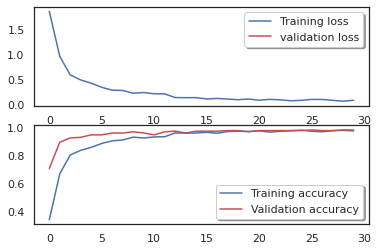

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

El modelo cuenta con una precisión de aproximadamente un 99%, por lo que podemos decir que es bastante preciso :D .

# Guardar modelo

Ahora vamos a guardar nuestro modelo para poder usarlo con ROS


In [ ]:
model.save("/tmp/pdm.h5")